## Importing the essential Libraries

In [2]:
import os
# Root = "D:/UWM_Classes/Sem_3/ML/Final_Project/Traffic_Sign_Recognition"
# os.chdir(Root)

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

## Dataset directory

In [507]:
data_dir = "gtsrb"
train_path = 'gtsrb/Train'
test_path = 'gtsrb/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [508]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [5]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Dataset Visualizing (Images in each class)

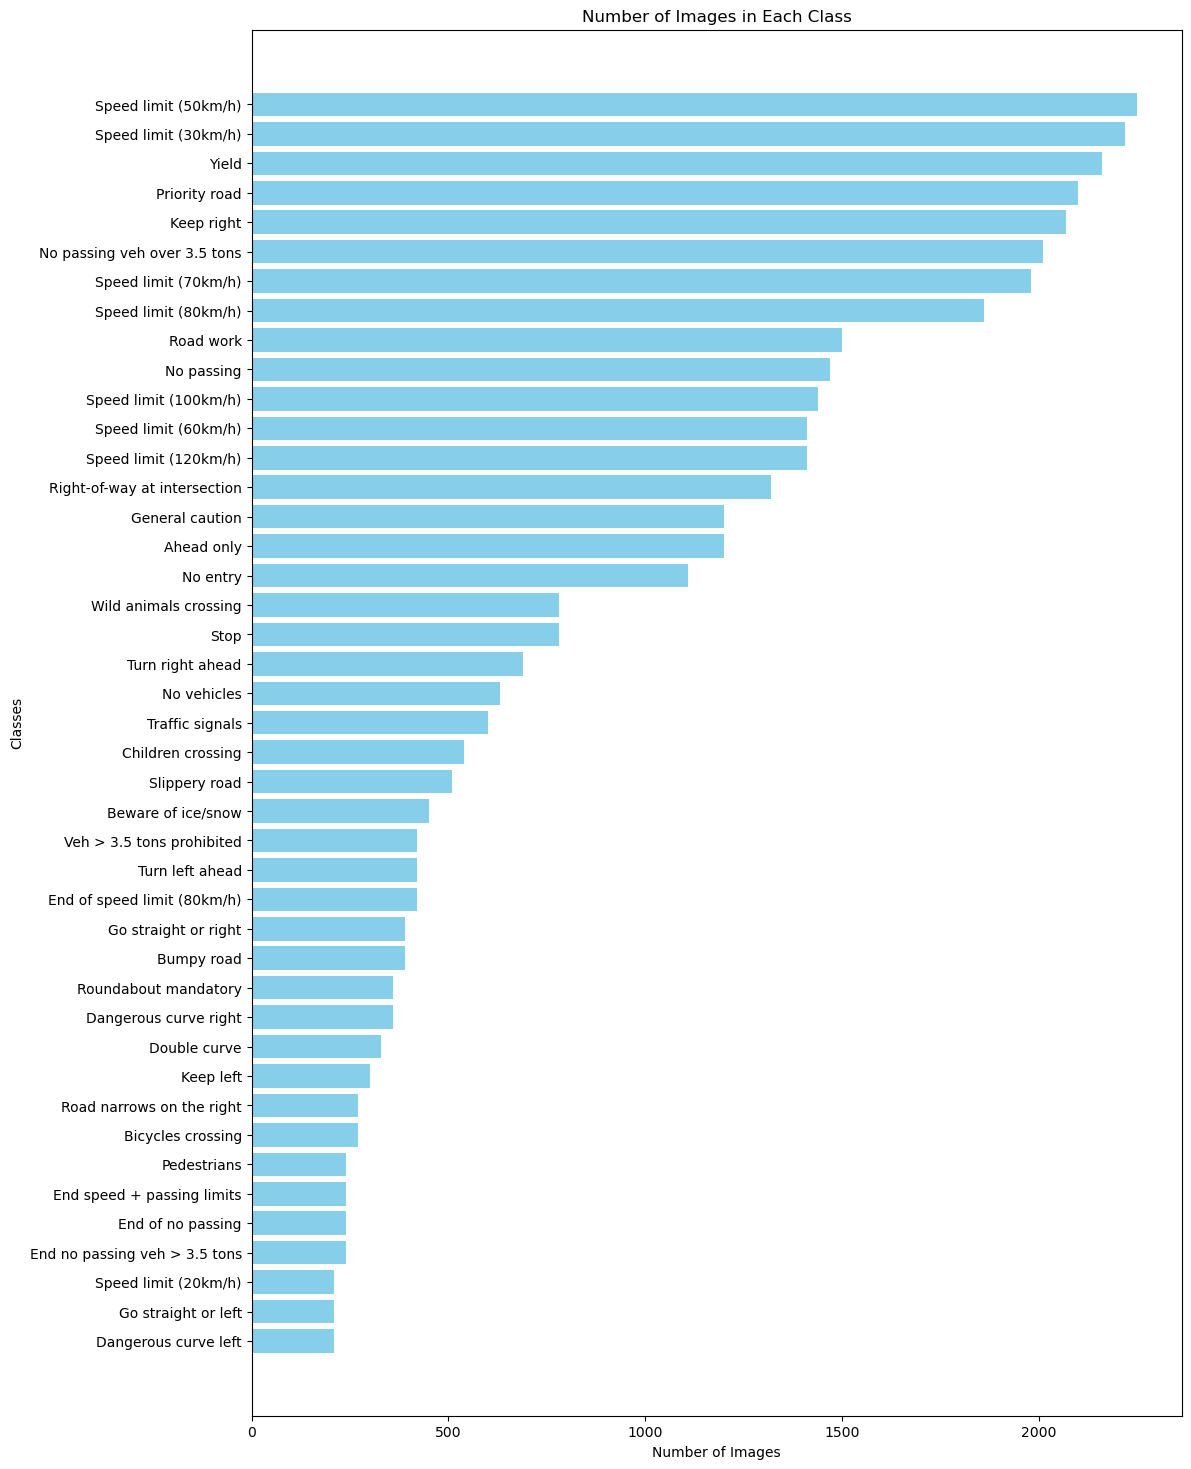

In [511]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

plt.figure(figsize=(12, 18))
plt.barh(class_num, train_number, color='skyblue')
plt.xlabel('Number of Images')
plt.ylabel('Classes')
plt.title('Number of Images in Each Class')
plt.show()

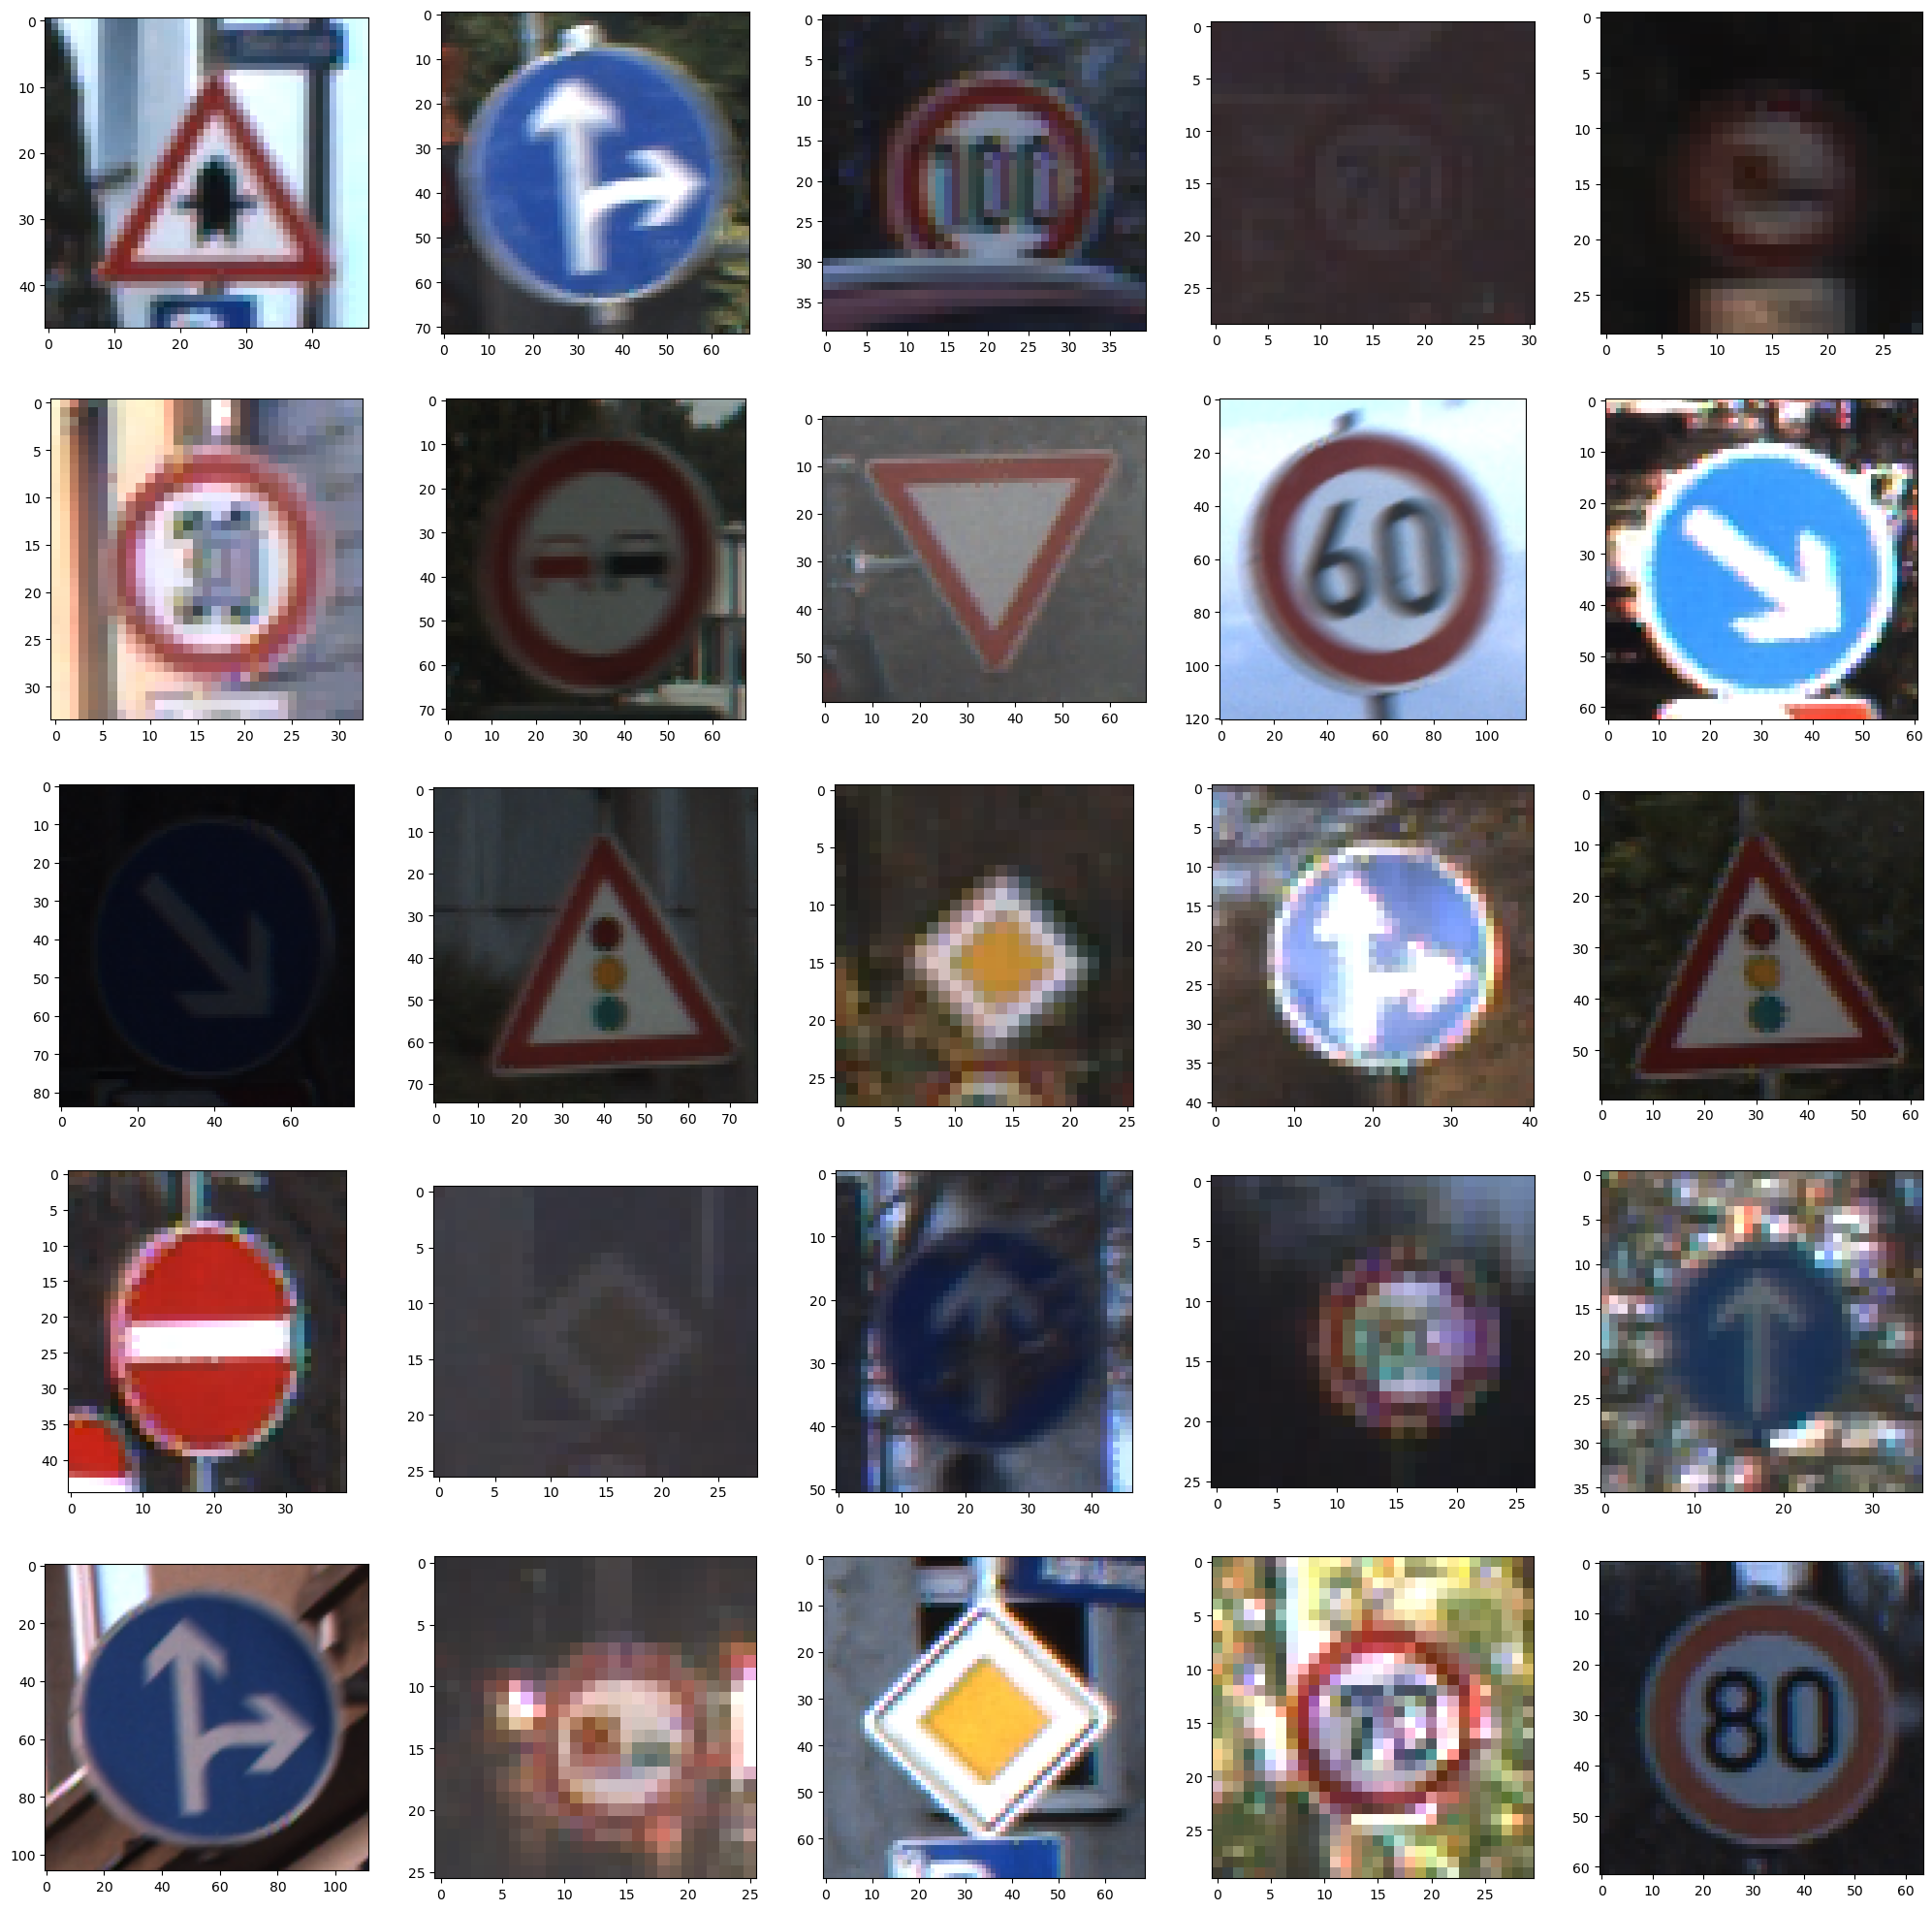

In [512]:
import random
from matplotlib.image import imread
import matplotlib.pyplot as plt

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25, 25))

for i in range(1, 26):
    plt.subplot(5, 5, i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(False) 
plt.show()

## Training Data

In [514]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Shuffling the training data

In [516]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into training and validation set

In [518]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

In [519]:
print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## One hot encoding

In [521]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## Models

### Model 1

In [524]:
from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.models import Model
from tensorflow.keras import layers, models

# Load the MobileNetV2 base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
model1 = models.Sequential([
    layers.Resizing(192, 192, input_shape=(IMG_HEIGHT, IMG_WIDTH, channels)),
    base_model,
    layers.GlobalAveragePooling2D(),  # Better than Flatten
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CATEGORIES, activation='softmax')  # NUM_CATEGORIES is the number of output classes
])

C:\Users\dssus\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Model 2

In [526]:
from tensorflow.keras import layers, models

# Define the sequential model
model2 = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, channels)),
    
    # First Convolutional Block
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.BatchNormalization(axis=-1),
    layers.Dropout(rate=0.3), 

    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.BatchNormalization(axis=-1),
    layers.Dropout(rate=0.5), 

    layers.Flatten(),  # Flattening Layer
    layers.Dense(512, activation='relu'),  # Fully Connected (Dense) Layer
    layers.BatchNormalization(),
    layers.Dropout(rate=0.5),

    # Output Layer
    layers.Dense(43, activation='softmax')
])


### Model 3

In [528]:
model3 = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, channels)),

    # First Convolutional Block
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.BatchNormalization(axis=-1),
    layers.Dropout(rate=0.3),

    # Second Convolutional Block
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.BatchNormalization(axis=-1),
    # layers.Dropout(rate=0.3),
    layers.Dropout(rate=0.5), #extra added

    layers.Flatten(), # Flattening Layer
    layers.Dense(512, activation='relu'), # Fully Connected (Dense) Layer
    layers.BatchNormalization(),
    layers.Dropout(rate=0.5),

     # Output Layer
    layers.Dense(NUM_CATEGORIES, activation='softmax')
])

In [530]:
epochs = 20

opt1 = Adam(learning_rate=0.001)
opt2 = Adam(learning_rate=0.001)
opt3 = Adam(learning_rate=0.0001)

# Compiling the models
model1.compile(loss='categorical_crossentropy', optimizer=opt1, metrics=['accuracy'])
model2.compile(loss='categorical_crossentropy', optimizer=opt2, metrics=['accuracy'])
model3.compile(loss='categorical_crossentropy', optimizer=opt3, metrics=['accuracy'])

## Augmenting the Training data 

In [532]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

## Training the Models

In [533]:
history1 = model1.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/20


C:\Users\dssus\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 174s 198ms/step - accuracy: 0.5358 - loss: 1.6997 - val_accuracy: 0.8304 - val_loss: 0.5442
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 200s 233ms/step - accuracy: 0.7639 - loss: 0.7474 - val_accuracy: 0.8432 - val_loss: 0.4983
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 211s 246ms/step - accuracy: 0.7937 - loss: 0.6374 - val_accuracy: 0.8731 - val_loss: 0.3968
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 206s 240ms/step - accuracy: 0.8110 - loss: 0.5808 - val_accuracy: 0.8698 - val_loss: 0.3975
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 200s 234ms/step - accuracy: 0.8234 - loss: 0.5409 - val_accuracy: 0.8717 - val_loss: 0.3911
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 197s 230ms/step - accuracy: 0.8341 - loss: 0.5096 - val_accuracy: 0.8953 - val_loss: 0.3330
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 207s 241ms/step - accuracy: 0.8403 - loss: 0.4925 - val_accuracy: 0.8791 - val_loss: 0.3643
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 211s 246ms/step - accuracy: 0.8494 - loss: 0.46

In [534]:
history2 = model2.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 38s 37ms/step - accuracy: 0.3682 - loss: 2.6270 - val_accuracy: 0.9410 - val_loss: 0.1856
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.8211 - loss: 0.5697 - val_accuracy: 0.9770 - val_loss: 0.0736
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.9006 - loss: 0.3151 - val_accuracy: 0.9926 - val_loss: 0.0252
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.9266 - loss: 0.2357 - val_accuracy: 0.9891 - val_loss: 0.0362
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.9378 - loss: 0.1980 - val_accuracy: 0.9935 - val_loss: 0.0183
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.9486 - loss: 0.1692 - val_accuracy: 0.9940 - val_loss: 0.0219
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.9533 - loss: 0.1468 - val_accuracy: 0.9918 - val_loss: 0.0267
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.9585 - loss: 0.1306 - 

In [535]:
history3 = model3.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 52s 57ms/step - accuracy: 0.1818 - loss: 3.7520 - val_accuracy: 0.7093 - val_loss: 0.9754
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 49s 57ms/step - accuracy: 0.5101 - loss: 1.7378 - val_accuracy: 0.8616 - val_loss: 0.4314
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 50s 59ms/step - accuracy: 0.6746 - loss: 1.0645 - val_accuracy: 0.9593 - val_loss: 0.1589
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 49s 57ms/step - accuracy: 0.7927 - loss: 0.6710 - val_accuracy: 0.9806 - val_loss: 0.0805
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 49s 57ms/step - accuracy: 0.8567 - loss: 0.4592 - val_accuracy: 0.9884 - val_loss: 0.0474
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 50s 58ms/step - accuracy: 0.9010 - loss: 0.3277 - val_accuracy: 0.9942 - val_loss: 0.0244
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 49s 57ms/step - accuracy: 0.9266 - loss: 0.2389 - val_accuracy: 0.9952 - val_loss: 0.0182
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 50s 58ms/step - accuracy: 0.9427 - loss: 0.1908 - 

## Saving the Models

In [537]:
model1.save("Model/model1.keras")

In [538]:
model2.save("Model/model2.keras")

In [539]:
model3.save("Model/model3.keras")

## Evaluating the model

In [541]:
print("X_train shape:", X_train.shape)
print("X_train min, max:", X_train.min(), X_train.max())
print("y_train shape:", y_train.shape)


X_train shape: (27446, 30, 30, 3)
X_train min, max: 0.0 1.0
y_train shape: (27446, 43)


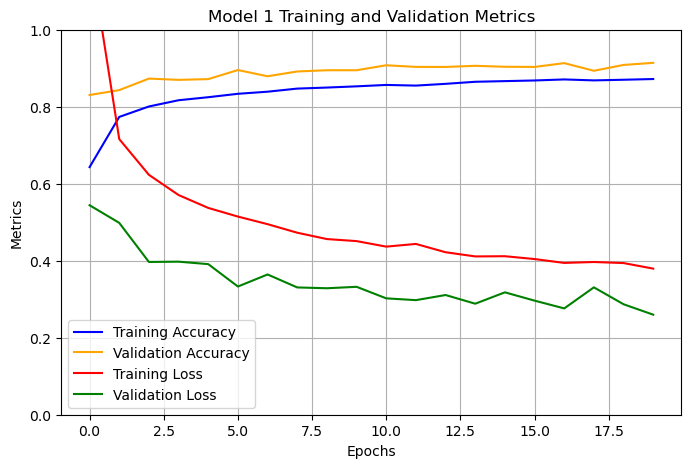

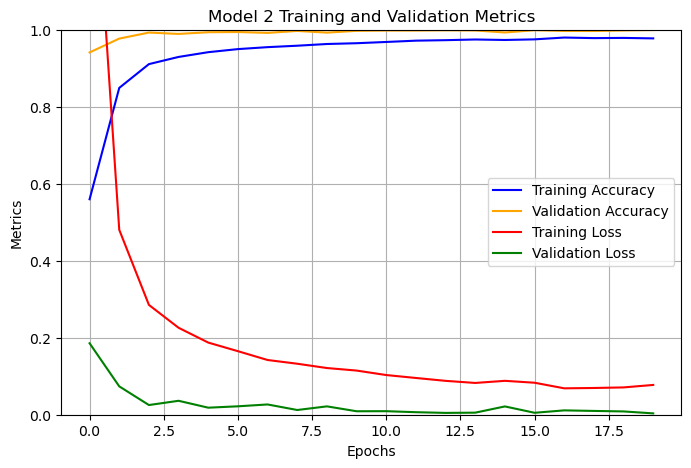

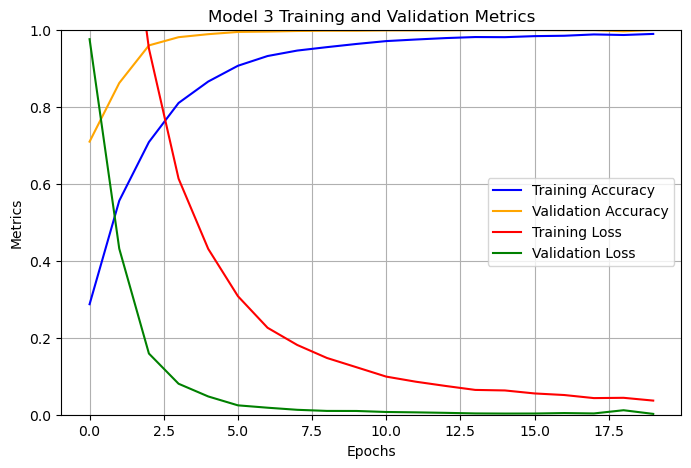

In [542]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics
def plot_model_metrics(history, model_name):
    plt.figure(figsize=(8, 5))

    # Plot accuracy
    plt.plot(history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', color='orange')

    # Plot loss
    plt.plot(history['loss'], label='Training Loss', color='red')
    plt.plot(history['val_loss'], label='Validation Loss', color='green')

    plt.title(f'{model_name} Training and Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.ylim(0, 1)  # Set consistent range for visibility
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for Model 1
plot_model_metrics(history1.history, 'Model 1')

# Plot for Model 2
plot_model_metrics(history2.history, 'Model 2')

# Plot for Model 3
plot_model_metrics(history3.history, 'Model 3')


In [543]:
# Loading the test data
test = pd.read_csv(data_dir + '/Test.csv')

# Extracting labels and image paths
labels = test["ClassId"].values
imgs = test["Path"].values

# Prepare image data
data = []
for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except Exception as e:
        print("Error in " + img, ":", e)

# Convert list to numpy array and normalize
X_test = np.array(data)
X_test = X_test / 255.0

In [544]:
# Evaluate Model 1
test_loss1, test_acc1 = model1.evaluate(X_test, keras.utils.to_categorical(labels, NUM_CATEGORIES))
print(f"Model 1 Test Accuracy: {test_acc1}")

# Evaluate Model 2
test_loss2, test_acc2 = model2.evaluate(X_test, keras.utils.to_categorical(labels, NUM_CATEGORIES))
print(f"Model 2 Test Accuracy: {test_acc2}")

# Evaluate Model 3
test_loss3, test_acc3 = model3.evaluate(X_test, keras.utils.to_categorical(labels, NUM_CATEGORIES))
print(f"Model 3 Test Accuracy: {test_acc3}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 61s 155ms/step - accuracy: 0.7932 - loss: 0.7556
Model 1 Test Accuracy: 0.7922406792640686
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9887 - loss: 0.0598
Model 2 Test Accuracy: 0.9881235361099243
395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9853 - loss: 0.0497
Model 3 Test Accuracy: 0.9851939678192139


## Visualizing the confusion matrix

395/395 ━━━━━━━━━━━━━━━━━━━━ 62s 154ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


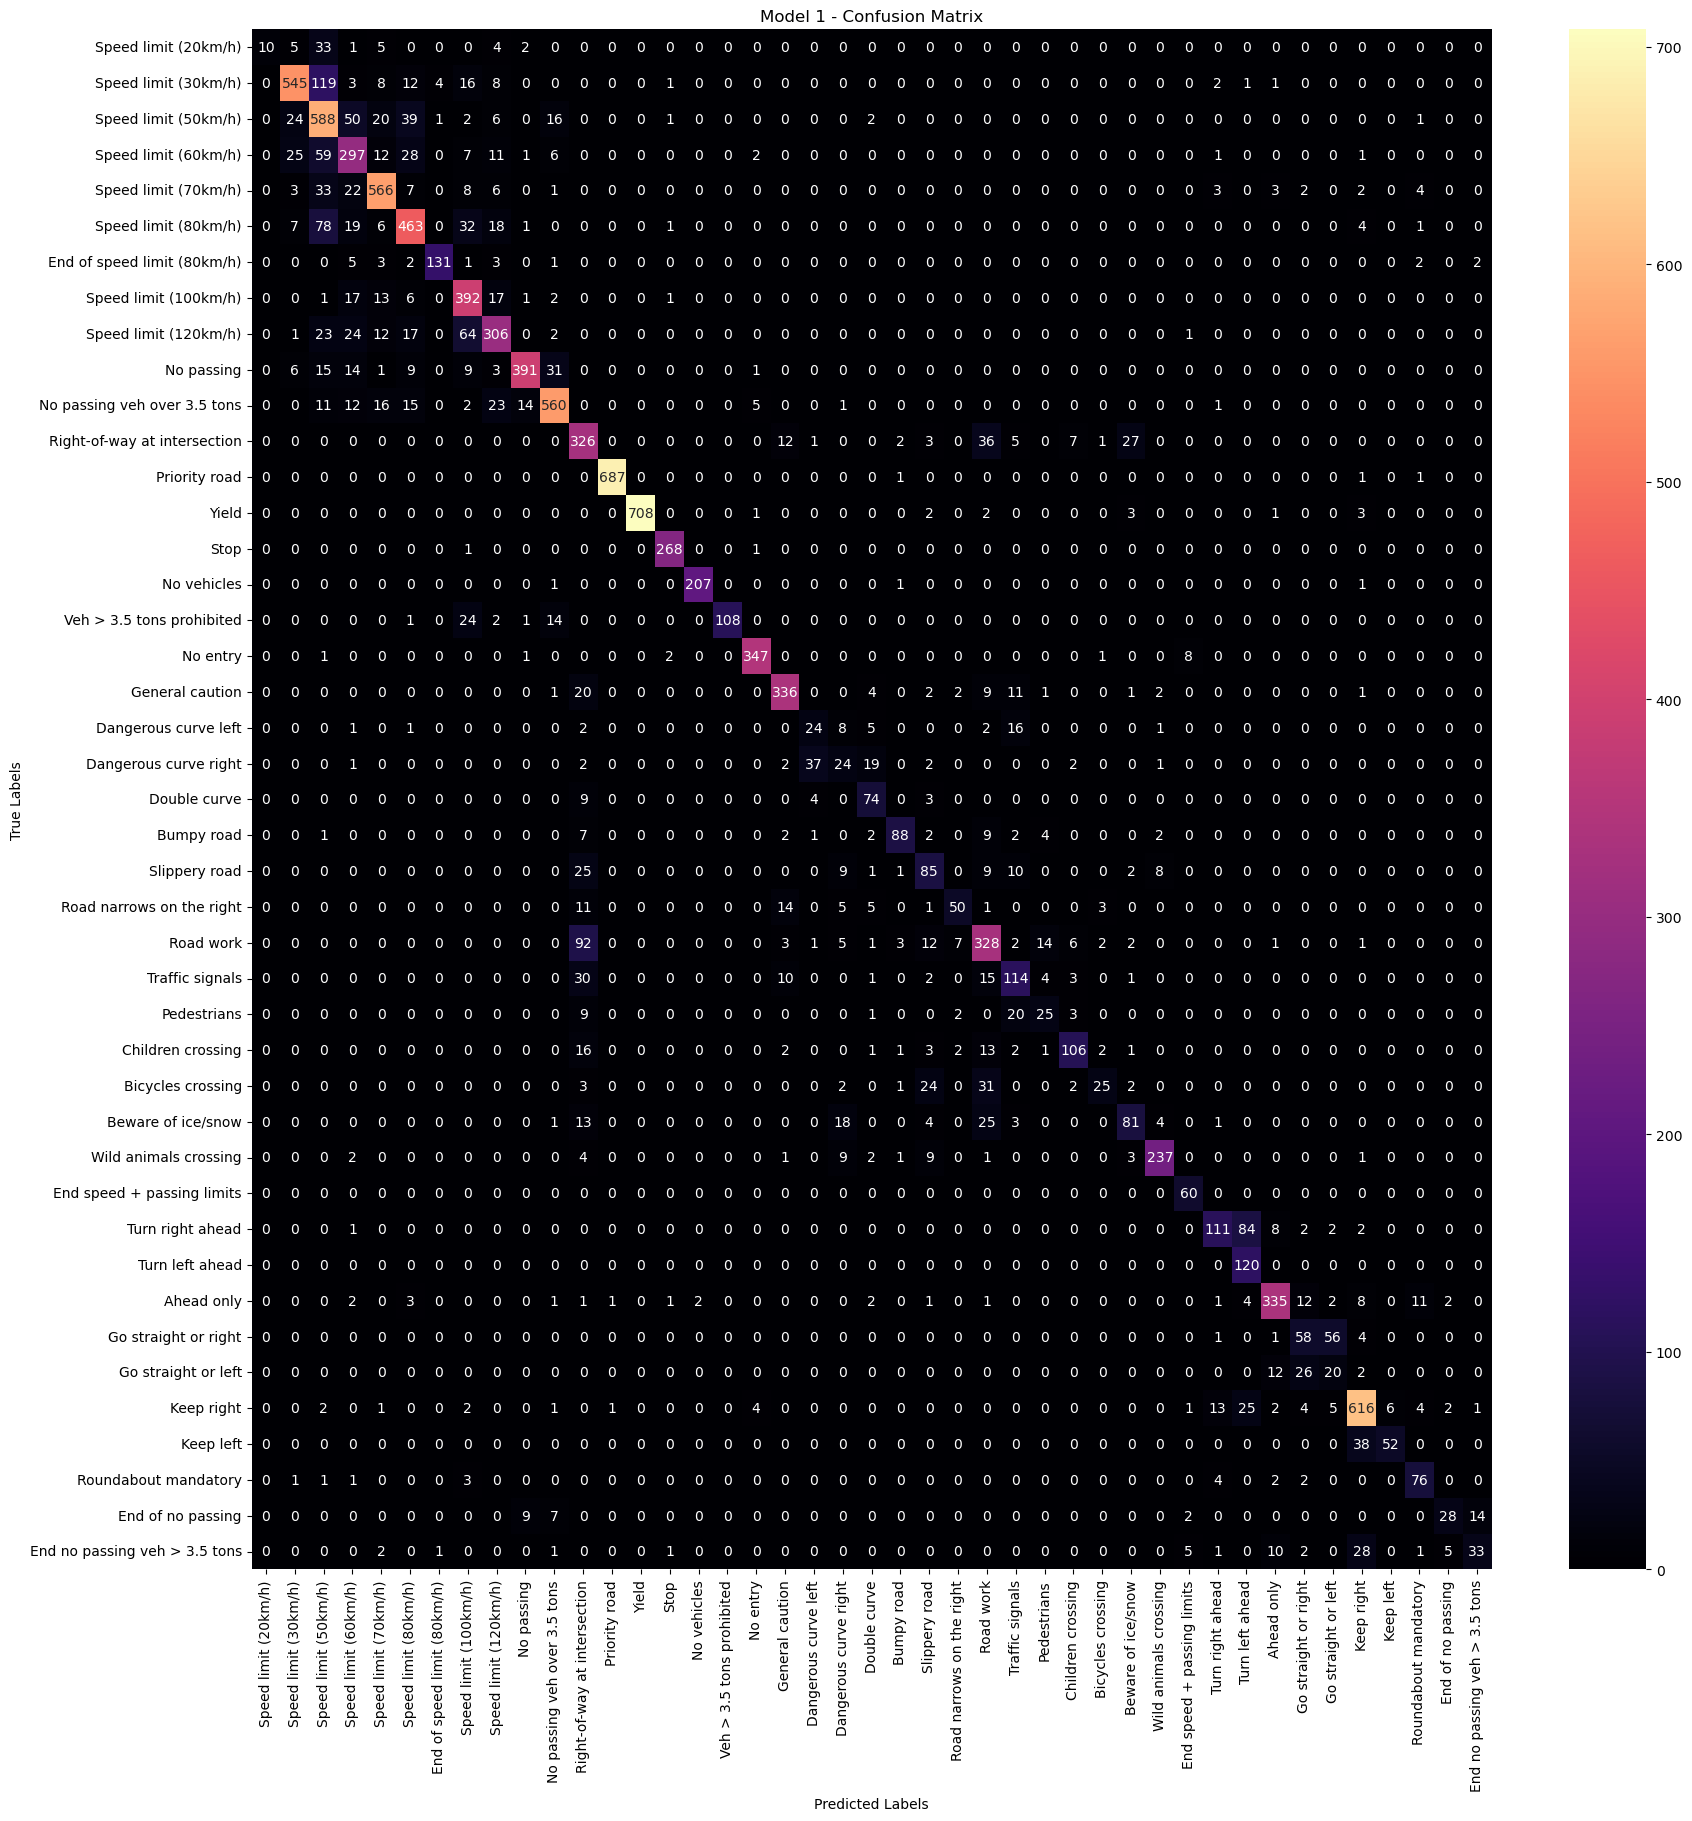

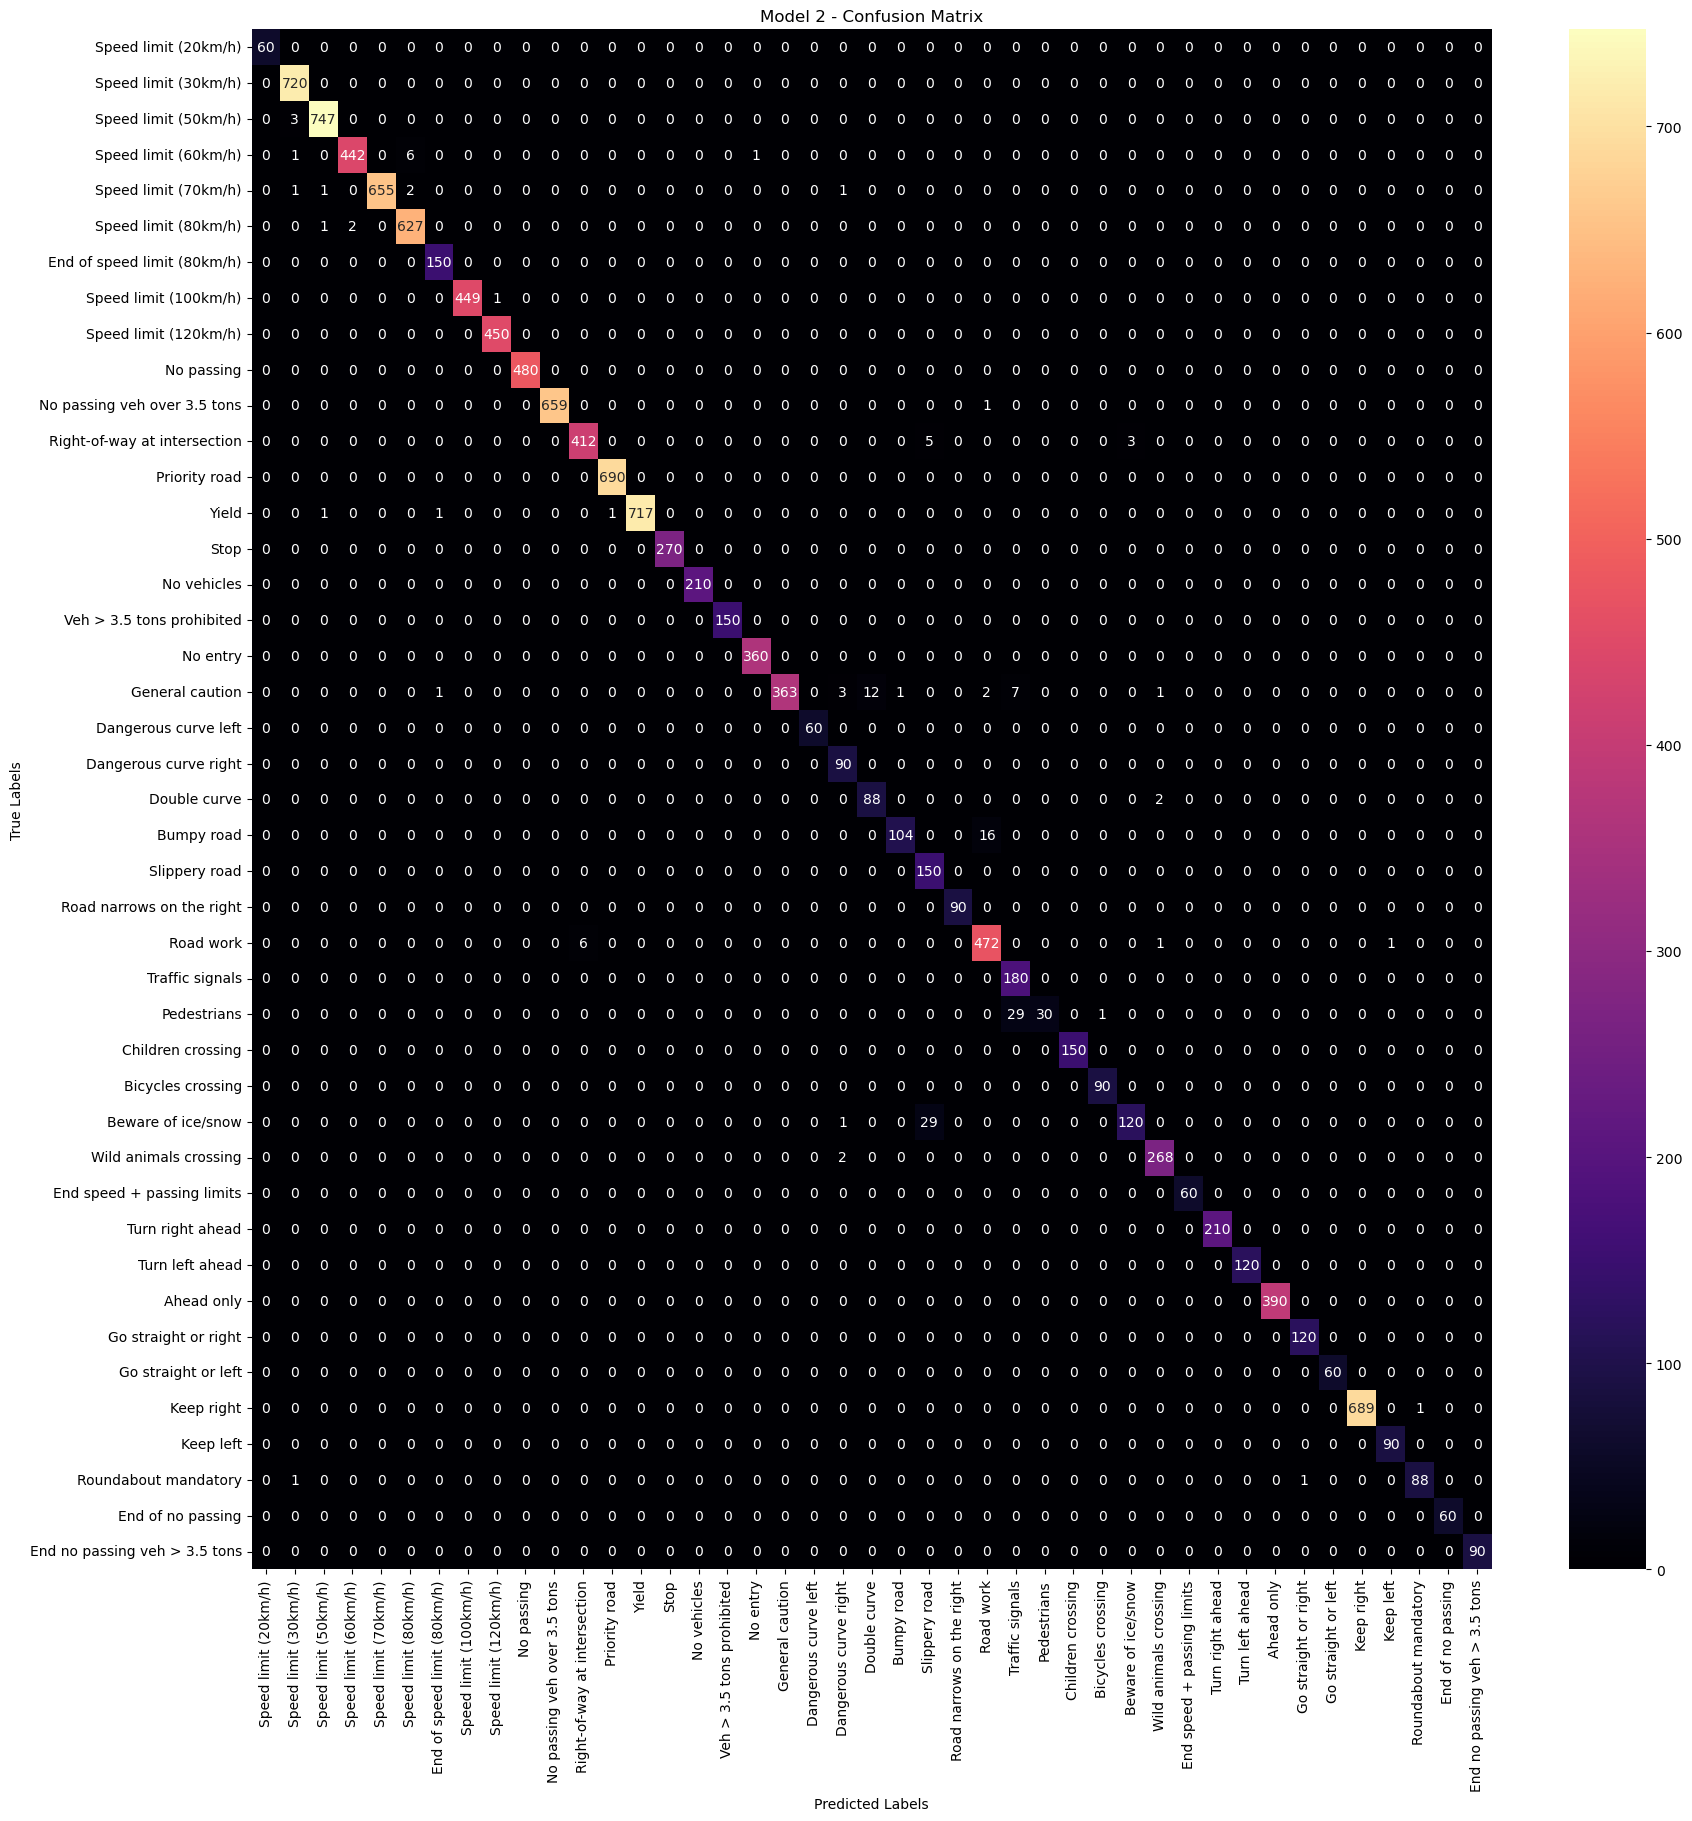

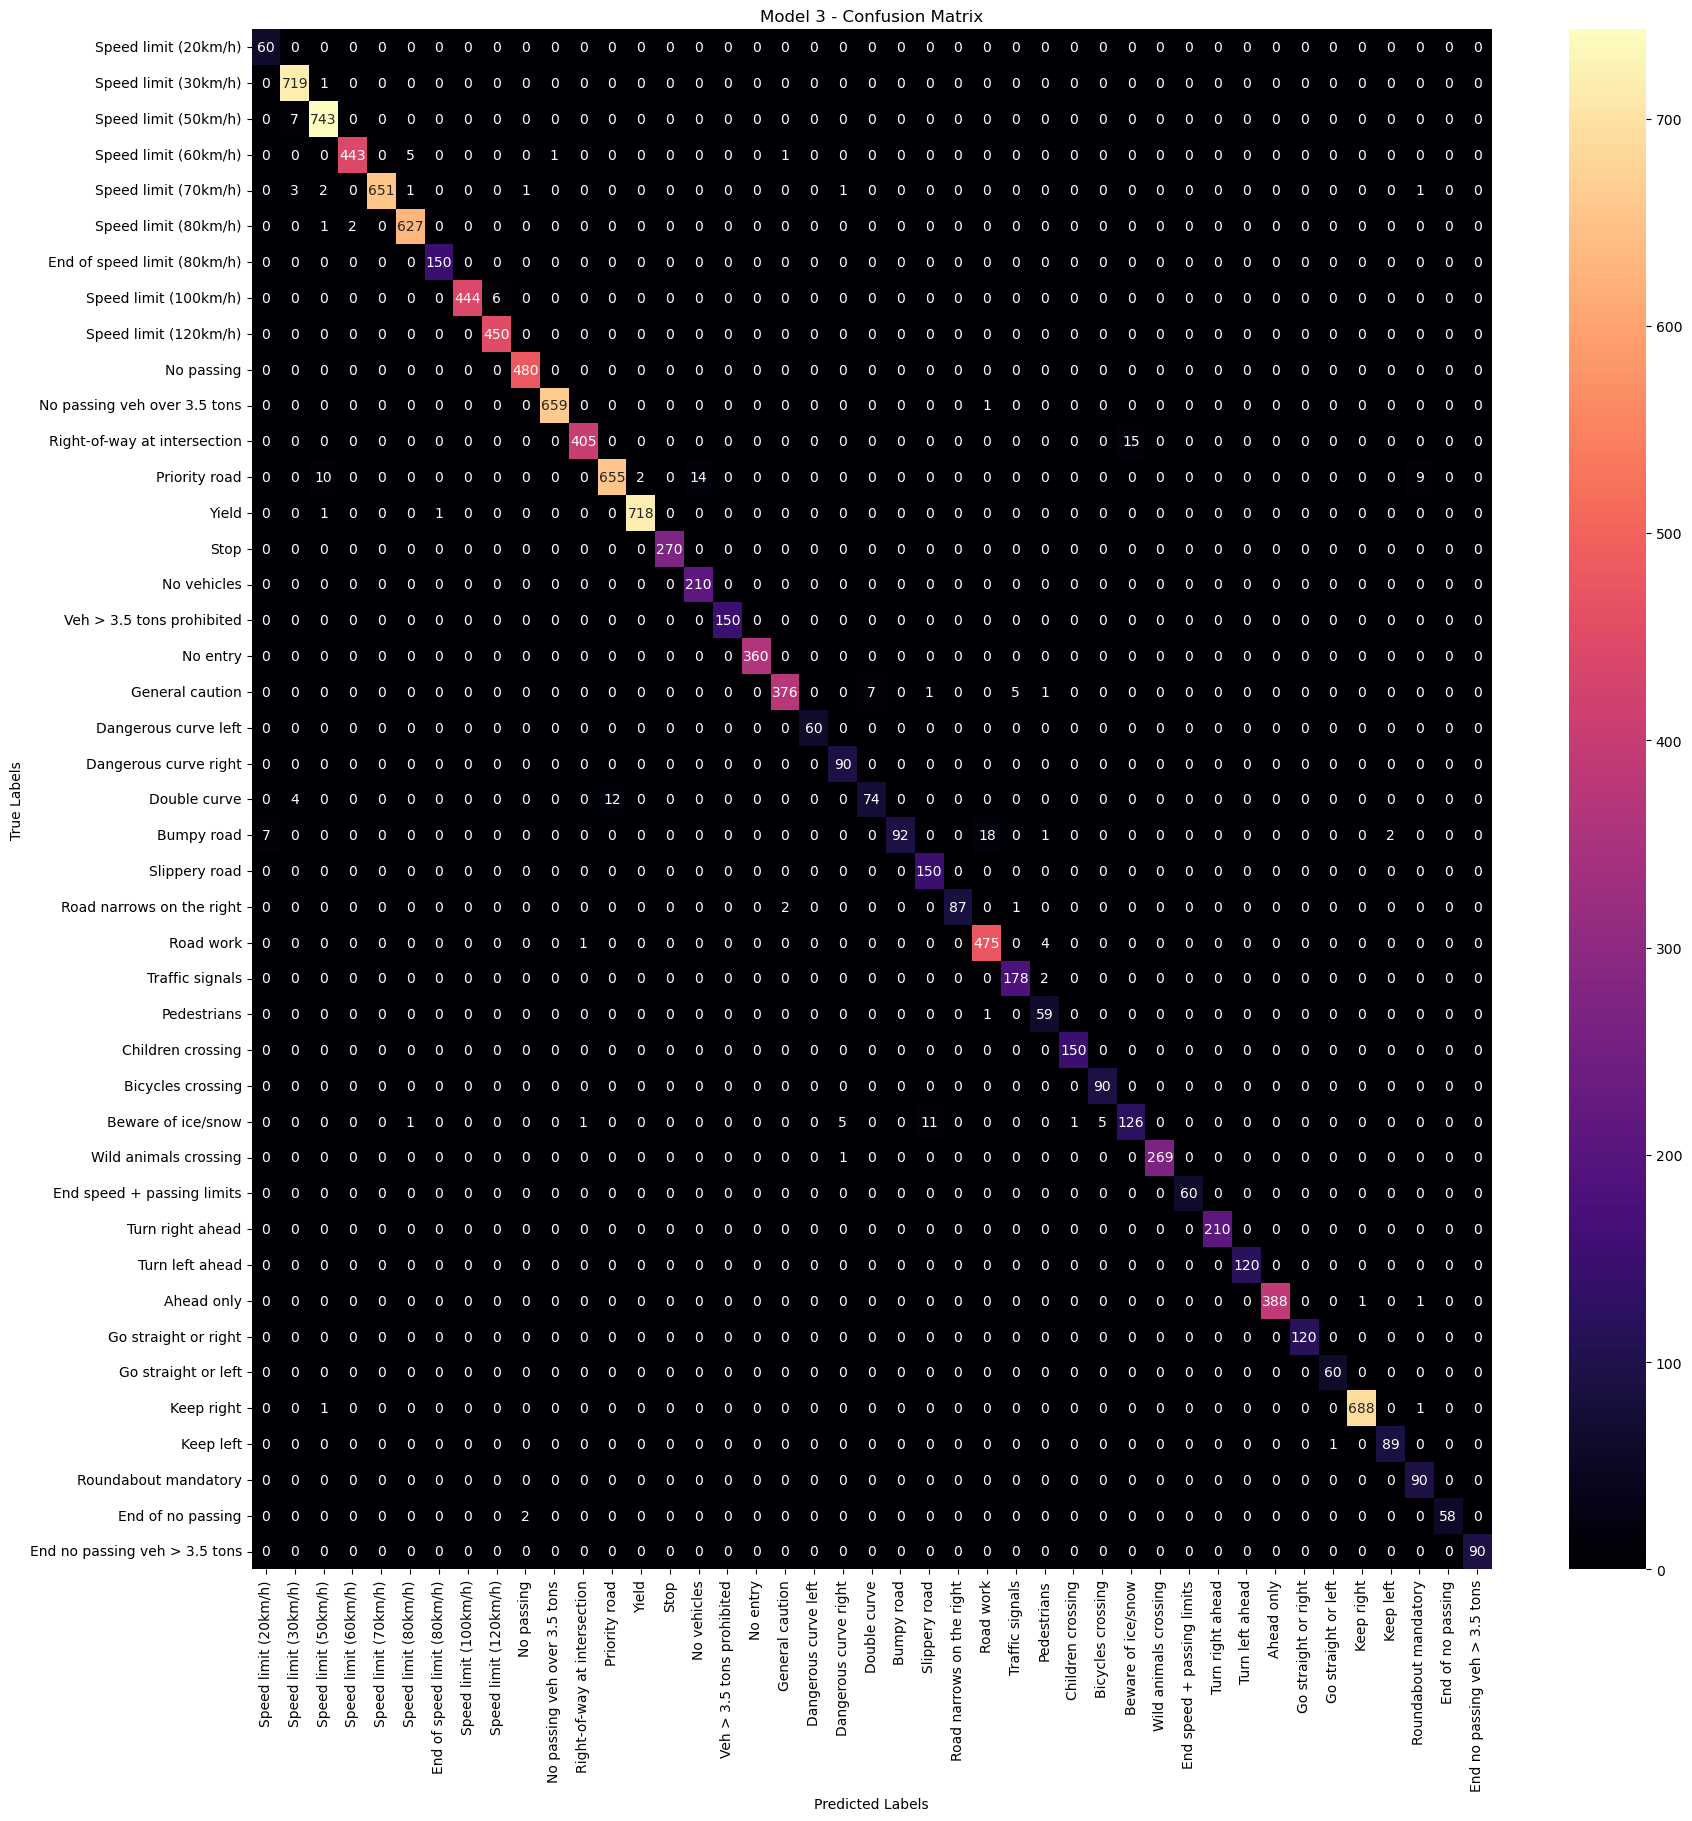

In [546]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, model_name, classes):
    """
    Function to generate and display the confusion matrix for a model.
    """
    # Ensure all 43 classes are considered
    cf_matrix = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    
    # Convert to DataFrame for better display
    df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(20, 20))  # Make the figure size larger
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="magma", cbar=True)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Predictions for all models
y_pred1 = np.argmax(model1.predict(X_test), axis=1)
y_pred2 = np.argmax(model2.predict(X_test), axis=1)
y_pred3 = np.argmax(model3.predict(X_test), axis=1)

# Class labels for plotting
class_names = list(classes.values())  # All 43 class names

# Plot confusion matrix for all 3 models
plot_confusion_matrix(labels, y_pred1, "Model 1", class_names)
plot_confusion_matrix(labels, y_pred2, "Model 2", class_names)
plot_confusion_matrix(labels, y_pred3, "Model 3", class_names)

In [4]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt


In [548]:
def evaluate_model(model, X_test, y_true, model_name):
    print(f"\n--- Evaluating {model_name} ---\n")
    
    # Get predictions
    y_pred_probs = model.predict(X_test)  # Probability predictions
    y_pred = np.argmax(y_pred_probs, axis=1)  # Class predictions
    
    # Convert true labels to one-hot encoding for multi-class ROC-AUC
    y_true_onehot = keras.utils.to_categorical(y_true, NUM_CATEGORIES)

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Classification Report
    report = classification_report(y_true, y_pred)
    print("Classification Report:\n", report)

In [549]:
# Convert y_true for test dataset
y_true = labels  # True labels

# Evaluate Model 1
evaluate_model(model1, X_test, y_true, "Model 1")

# Evaluate Model 2
evaluate_model(model2, X_test, y_true, "Model 2")

# Evaluate Model 3
evaluate_model(model3, X_test, y_true, "Model 3")



--- Evaluating Model 1 ---

395/395 ━━━━━━━━━━━━━━━━━━━━ 60s 153ms/step
Accuracy: 0.7922
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.17      0.29        60
           1       0.88      0.76      0.82       720
           2       0.61      0.78      0.69       750
           3       0.63      0.66      0.64       450
           4       0.85      0.86      0.85       660
           5       0.77      0.73      0.75       630
           6       0.96      0.87      0.91       150
           7       0.70      0.87      0.77       450
           8       0.75      0.68      0.71       450
           9       0.93      0.81      0.87       480
          10       0.87      0.85      0.86       660
          11       0.57      0.78      0.66       420
          12       1.00      1.00      1.00       690
          13       1.00      0.98      0.99       720
          14       0.97      0.99      0.98       270
          15       0.

In [550]:
def evaluate_predictions(y_true, y_pred, model_name):
    # Find correct predictions
    correct_predictions = np.sum(y_true == y_pred)
    total_images = len(y_true)
    incorrect_predictions = total_images - correct_predictions

    # Print results
    print(f"\n--- {model_name} ---")
    print(f"Total Images: {total_images}")
    print(f"Correct Predictions: {correct_predictions}")
    print(f"Incorrect Predictions: {incorrect_predictions}")
    print(f"Accuracy: {correct_predictions / total_images:.4f}")

    # Optionally, display example indices of incorrect predictions
    incorrect_indices = np.where(y_true != y_pred)[0]
    print(f"Example Incorrect Prediction Indices: {incorrect_indices[:10]}")  # Display first 10

# Predictions for all models
y_pred1 = np.argmax(model1.predict(X_test), axis=1)
y_pred2 = np.argmax(model2.predict(X_test), axis=1)
y_pred3 = np.argmax(model3.predict(X_test), axis=1)

# Evaluate predictions for each model
evaluate_predictions(labels, y_pred1, "Model 1")
evaluate_predictions(labels, y_pred2, "Model 2")
evaluate_predictions(labels, y_pred3, "Model 3")


395/395 ━━━━━━━━━━━━━━━━━━━━ 60s 153ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step

--- Model 1 ---
Total Images: 12630
Correct Predictions: 10006
Incorrect Predictions: 2624
Accuracy: 0.7922
Example Incorrect Prediction Indices: [ 3 13 17 23 33 39 45 46 50 55]

--- Model 2 ---
Total Images: 12630
Correct Predictions: 12480
Incorrect Predictions: 150
Accuracy: 0.9881
Example Incorrect Prediction Indices: [237 309 339 421 443 492 501 550 677 708]

--- Model 3 ---
Total Images: 12630
Correct Predictions: 12443
Incorrect Predictions: 187
Accuracy: 0.9852
Example Incorrect Prediction Indices: [114 127 265 309 339 443 475 492 496 513]


In [551]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_model_overall(models, X_test, y_true, model_names):
    """
    Evaluate multiple models and plot ROC curves on one graph.
    
    Args:
        models (list): List of trained models.
        X_test (array): Test data.
        y_true (array): True labels.
        model_names (list): List of model names (str) corresponding to each model.
    """
    plt.figure(figsize=(10, 8))  
    
    for model, model_name in zip(models, model_names):
        print(f"\n--- Evaluating {model_name} ---\n")
        
        # Get predictions
        y_pred_probs = model.predict(X_test)  # Probability predictions
        y_pred = np.argmax(y_pred_probs, axis=1)  # Class predictions
        
        # Convert true labels to one-hot encoding for ROC-AUC calculation
        y_true_onehot = keras.utils.to_categorical(y_true, NUM_CATEGORIES)

        # Accuracy
        accuracy = accuracy_score(y_true, y_pred)
        print(f"Accuracy: {accuracy:.4f}")
        
        # Precision, Recall, F1-Score 
        report = classification_report(y_true, y_pred, digits=4, output_dict=True)
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        f1_score = report['weighted avg']['f1-score']
        
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1_score:.4f}")
        
        # Overall ROC-AUC Score 
        roc_auc = roc_auc_score(y_true_onehot, y_pred_probs, multi_class="ovr", average="macro")
        print(f"ROC-AUC Score: {roc_auc:.8f}")
        
        # Compute ROC curve and AUC 
        fpr = {}
        tpr = {}
        all_fpr = np.unique(np.concatenate([roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])[0] for i in range(NUM_CATEGORIES)]))
        mean_tpr = np.zeros_like(all_fpr)
        
        for i in range(NUM_CATEGORIES):
            fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        
        mean_tpr /= NUM_CATEGORIES
        macro_auc = auc(all_fpr, mean_tpr)

        # Plot ROC curve for the current model
        plt.plot(all_fpr, mean_tpr, label=f'{model_name} (AUC = {macro_auc:.2f})')
    
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Overall ROC Curves for All Models')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()



--- Evaluating Model 1 ---

395/395 ━━━━━━━━━━━━━━━━━━━━ 60s 153ms/step
Accuracy: 0.7922
Precision: 0.8056
Recall: 0.7922
F1-Score: 0.7919
ROC-AUC Score: 0.99051045

--- Evaluating Model 2 ---

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 0.9881
Precision: 0.9892
Recall: 0.9881
F1-Score: 0.9878
ROC-AUC Score: 0.99987625

--- Evaluating Model 3 ---

395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
Accuracy: 0.9852
Precision: 0.9856
Recall: 0.9852
F1-Score: 0.9850
ROC-AUC Score: 0.99995824


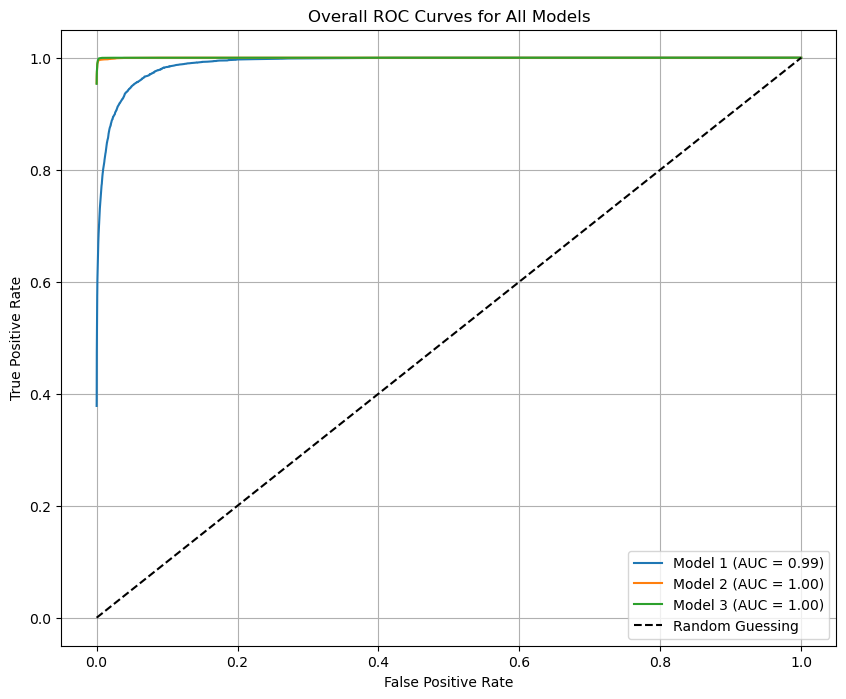

In [552]:
# Wrap models in a list and define their names
models = [model1, model2, model3]
model_names = ["Model 1", "Model 2", "Model 3"]

# Call the function with the list
evaluate_model_overall(models, X_test, labels, model_names)


In [553]:
import pandas as pd

# Function to extract final metrics for a model
def get_model_metrics(history, model, X_test, y_true, model_name):
    # Loss and Accuracy from training history
    final_loss = history.history['loss'][-1]
    final_accuracy = history.history['accuracy'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    
    # Calculate ROC-AUC score
    y_pred_probs = model.predict(X_test)
    y_true_onehot = keras.utils.to_categorical(y_true, NUM_CATEGORIES)
    roc_auc = roc_auc_score(y_true_onehot, y_pred_probs, multi_class="ovr", average="macro")
    
    # Return the metrics as a dictionary
    return {
        'Model': model_name,
        'Loss': round(final_loss, 4),
        'Accuracy': round(final_accuracy, 4),
        'Validation Loss': round(final_val_loss, 4),
        'Validation Accuracy': round(final_val_accuracy, 4),
        'AUC': round(roc_auc, 8)
    }

# Collect metrics for each model
metrics_model1 = get_model_metrics(history1, model1, X_test, labels, "Model 1")
metrics_model2 = get_model_metrics(history2, model2, X_test, labels, "Model 2")
metrics_model3 = get_model_metrics(history3, model3, X_test, labels, "Model 3")

# Create a pandas DataFrame to display the results
results_df = pd.DataFrame([metrics_model1, metrics_model2, metrics_model3])

# Display the table
print(results_df)


395/395 ━━━━━━━━━━━━━━━━━━━━ 61s 154ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
     Model    Loss  Accuracy  Validation Loss  Validation Accuracy       AUC
0  Model 1  0.3795    0.8719           0.2598               0.9140  0.990510
1  Model 2  0.0773    0.9775           0.0035               0.9991  0.999876
2  Model 3  0.0367    0.9891           0.0022               0.9993  0.999958


#### Based on all these Visualizations and evaluating the models, The best model is Model 3

## Predicting on Test Data

In [567]:
# Get predictions from the best model

# Here the best model is Model 3

pred_probs_test = model3.predict(X_test)
pred_test = np.argmax(pred_probs_test, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


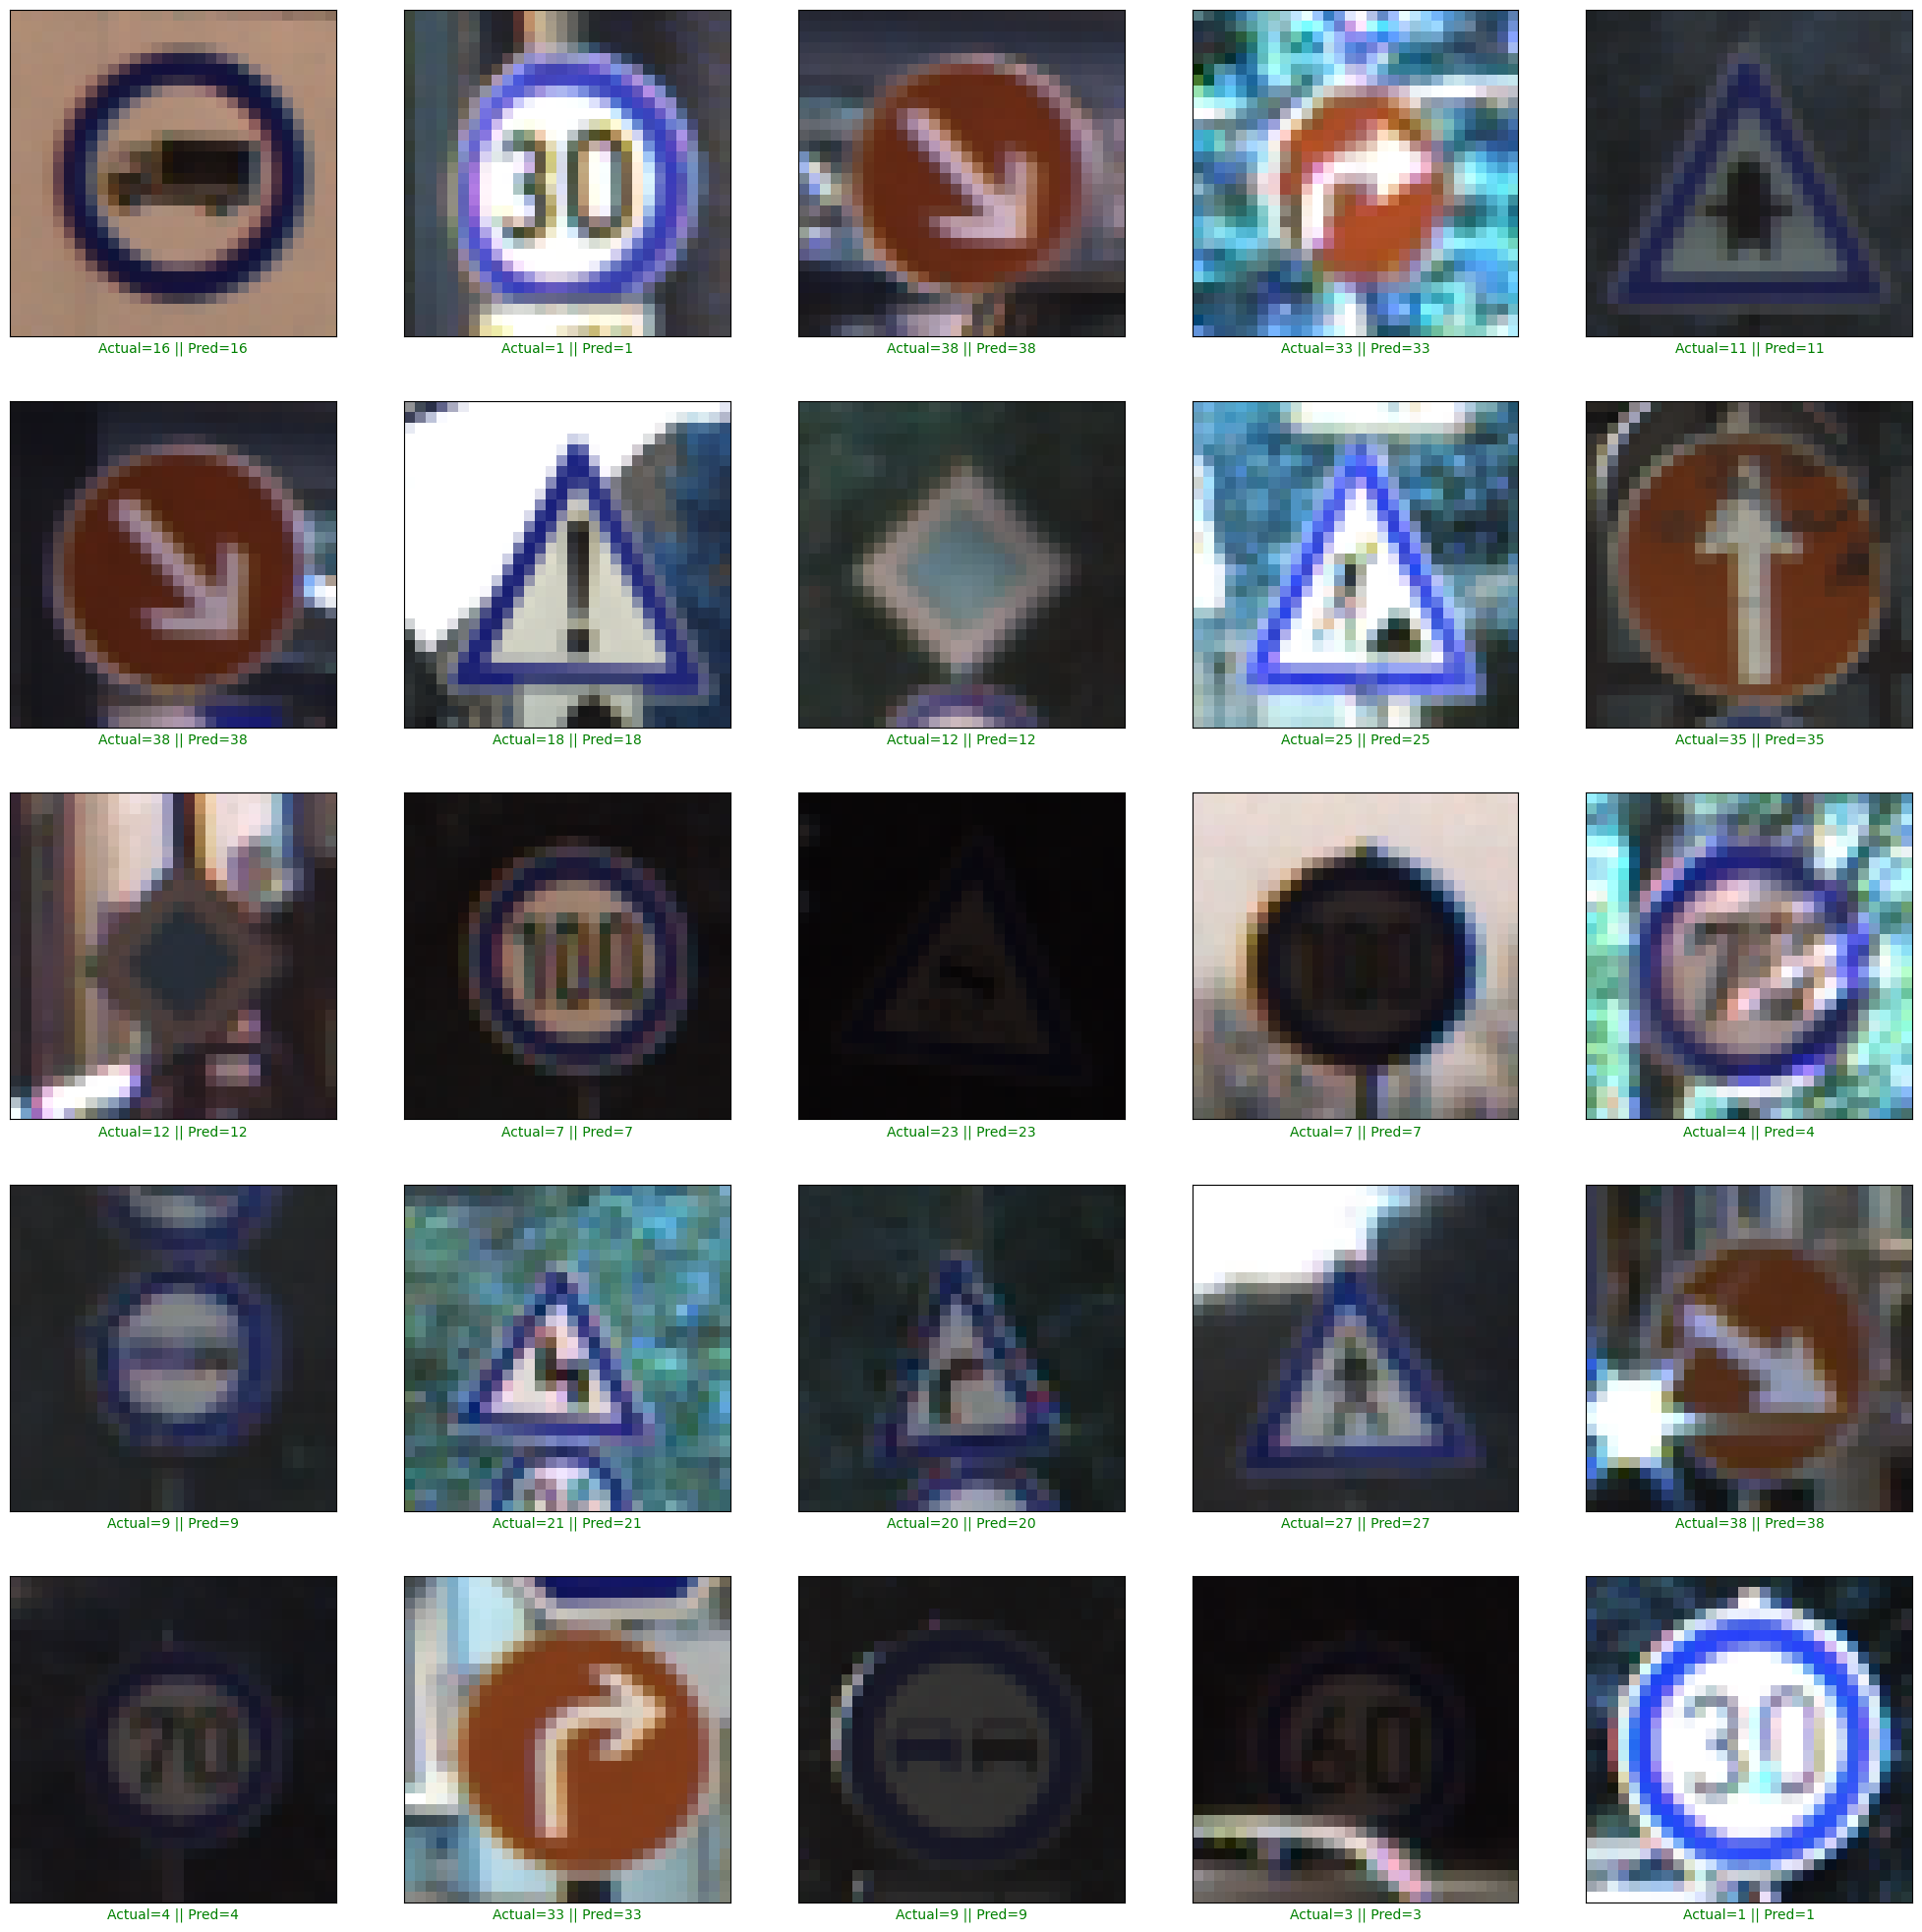

In [569]:
#Predcting the iamges along with the actual and predicted labels
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred_test[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


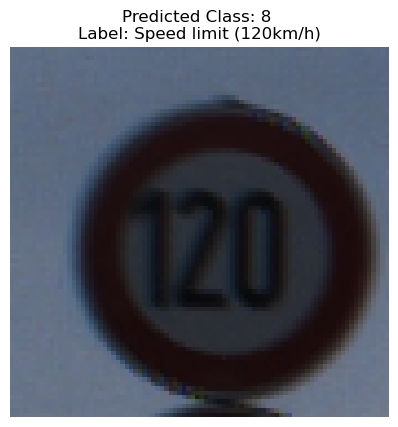

Predicted class for the single image: 8
Label: Speed limit (120km/h)


In [8]:
# Predicting the single image
model_path = "Model/model3.keras"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

# Load and preprocess the image
image_path = "gtsrb/Test/00123.png"
image = cv2.imread(image_path)
image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((30, 30))
expand_input = np.expand_dims(resize_image, axis=0)
input_data = np.array(expand_input)
input_data = input_data / 255.0

# Predict the class
pred_single = loaded_model.predict(input_data)
result = np.argmax(pred_single)
label = classes[result]

# Display the image with predicted label
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
plt.title(f"Predicted Class: {result} \nLabel: {label}")
plt.axis('off')  # Remove axes for cleaner display
plt.show()

print("Predicted class for the single image:", result)
print("Label:", label)